In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset

import os
import numpy as np

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import TrainingArguments, Trainer, ViTImageProcessor, ViTForImageClassification, DefaultDataCollator

In [2]:
model_name = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_name)
image_size, image_mean, image_std = processor.size, processor.image_mean, processor.image_std
print(f"Image size: {image_size}, Image mean: {image_mean}, Image std: {image_std}")

Image size: {'height': 224, 'width': 224}, Image mean: [0.5, 0.5, 0.5], Image std: [0.5, 0.5, 0.5]


In [3]:
transform = transforms.Compose([
    transforms.Resize((image_size['height'], image_size['width'])),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class ViTImageDataset(Dataset):
    def __init__(self, image_folder, processor):
        self.processor = processor
        self.dataset = datasets.ImageFolder(root=image_folder)
        self.classes = self.dataset.classes
        self.class_to_idx = self.dataset.class_to_idx
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        processed = self.processor(images=image, return_tensors="pt")
        return {"pixel_values": processed["pixel_values"].squeeze(), "labels": label}


### CIFAKE Training and Evaluation

In [5]:
train_dataset = ViTImageDataset('../data/train', processor)
test_dataset = ViTImageDataset('../data/test', processor)

In [6]:
labels = train_dataset.classes
num_classes = len(labels)
label2idx = train_dataset.class_to_idx
idx2label = {v: k for k, v in label2idx.items()}

In [7]:
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)
model.to(device)
model.config.id2label = idx2label
model.config.label2id = label2idx

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
args = TrainingArguments(
    output_dir='vit results/cifake',
    num_train_epochs=1,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    evaluation_strategy='epoch',
    learning_rate=3e-6,
    weight_decay=0.02,
    warmup_steps=50,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=2
)

In [9]:
def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['labels'] for example in examples])
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

In [10]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=processor
)

In [11]:
trainer.train()

  0%|          | 0/1563 [00:00<?, ?it/s]

{'loss': 0.4635, 'grad_norm': 1.140637993812561, 'learning_rate': 2.1077329808327824e-06, 'epoch': 0.32}
{'loss': 0.1506, 'grad_norm': 2.5881850719451904, 'learning_rate': 1.1163251817580966e-06, 'epoch': 0.64}
{'loss': 0.1216, 'grad_norm': 0.897315263748169, 'learning_rate': 1.2491738268341044e-07, 'epoch': 0.96}


  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.11617913842201233, 'eval_runtime': 436.6502, 'eval_samples_per_second': 45.803, 'eval_steps_per_second': 0.717, 'epoch': 1.0}
{'train_runtime': 25114.5546, 'train_samples_per_second': 3.982, 'train_steps_per_second': 0.062, 'train_loss': 0.23951207012681724, 'epoch': 1.0}


TrainOutput(global_step=1563, training_loss=0.23951207012681724, metrics={'train_runtime': 25114.5546, 'train_samples_per_second': 3.982, 'train_steps_per_second': 0.062, 'train_loss': 0.23951207012681724, 'epoch': 1.0})

In [16]:
trainer.save_model('saved_models/vit_cifar10')

In [12]:
trainer.evaluate()

  0%|          | 0/313 [00:00<?, ?it/s]

{'eval_loss': 0.11617913842201233,
 'eval_runtime': 198.2157,
 'eval_samples_per_second': 100.9,
 'eval_steps_per_second': 1.579,
 'epoch': 1.0}

In [13]:
output = trainer.predict(test_dataset)
y_true = output.label_ids
y_pred = output.predictions.argmax(axis=1)

  0%|          | 0/313 [00:00<?, ?it/s]

In [14]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.9657
Classification report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     10000
           1       0.97      0.96      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



Confusion matrix:
[[9681  319]
 [ 367 9633]]


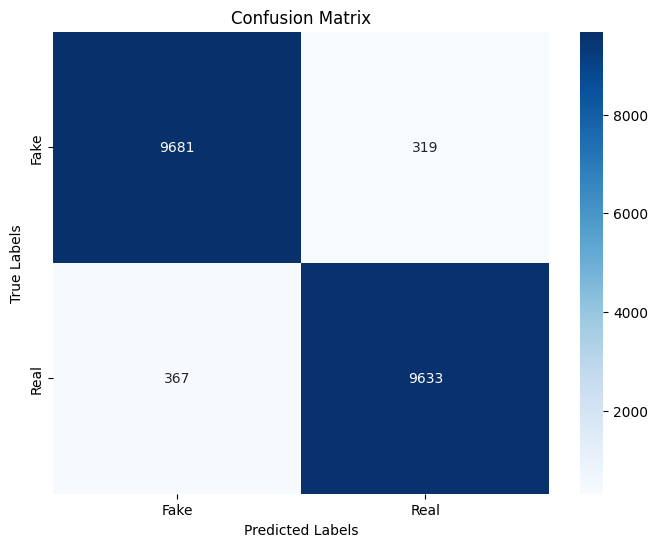

In [17]:
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'], va='center')
plt.show()

### FakeNet Evaluation

In [5]:
test_dataset = ViTImageDataset('../FakeNet', processor)

In [6]:
labels = test_dataset.classes
num_classes = len(labels)
label2idx = test_dataset.class_to_idx
idx2label = {v: k for k, v in label2idx.items()}

In [7]:
model = ViTForImageClassification.from_pretrained('saved_models/vit_cifar10')
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [8]:
args = TrainingArguments(
    output_dir='vit results/FakeNet',
    per_device_eval_batch_size=64,
    do_train=False,
    do_predict=True
)

In [10]:
def collate_fn(examples):
    pixel_values = torch.stack([example['pixel_values'] for example in examples])
    labels = torch.tensor([example['labels'] for example in examples])
    return {
        'pixel_values': pixel_values,
        'labels': labels
    }

In [11]:
trainer = Trainer(
    model=model,
    args=args,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
    tokenizer=processor
)

In [12]:
results = trainer.evaluate()

  0%|          | 0/157 [00:00<?, ?it/s]

In [13]:
output = trainer.predict(test_dataset)
y_true = output.label_ids
y_pred = output.predictions.argmax(axis=1)

  0%|          | 0/157 [00:00<?, ?it/s]

In [14]:
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification report:")
print(classification_report(y_true, y_pred))

Accuracy: 0.6377377377377378
Classification report:
              precision    recall  f1-score   support

           0       0.64      0.61      0.63      4990
           1       0.63      0.66      0.65      5000

    accuracy                           0.64      9990
   macro avg       0.64      0.64      0.64      9990
weighted avg       0.64      0.64      0.64      9990



Confusion matrix:
[[3064 1926]
 [1693 3307]]


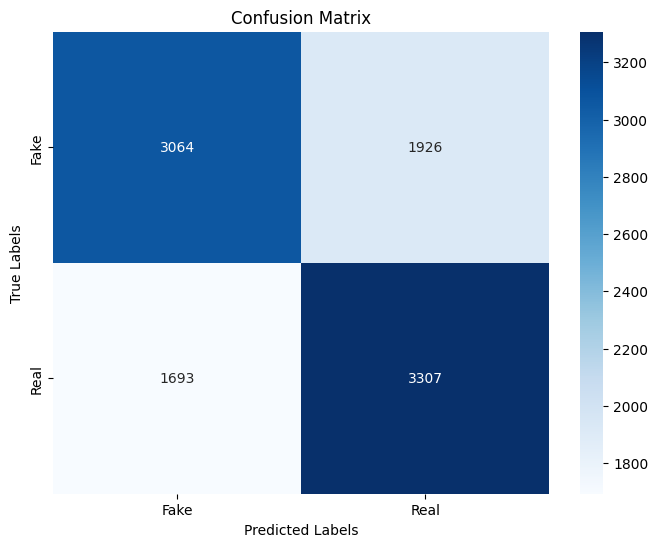

In [15]:
cm = confusion_matrix(y_true, y_pred)
print('Confusion matrix:')
print(cm)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks([0.5, 1.5], ['Fake', 'Real'])
plt.yticks([0.5, 1.5], ['Fake', 'Real'], va='center')
plt.show()